<h1 style="text-align:center;"><b>Laboratorio 3</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Importación y preprocesamiento de datos 

In [4]:
def cargar_modalidad_desde_nombre(path_mod):
    images = []
    labels = []
    for fname in sorted(os.listdir(path_mod)):
        if fname.endswith('.png'):
            label = int(fname.split('.')[1])
            img_path = os.path.join(path_mod, fname)
            img = Image.open(img_path).convert('RGB') 
            images.append(np.array(img))
            labels.append(label)
    return np.stack(images), np.array(labels)

In [5]:
base_path = '/Users/arielamishaancohen/Documents/Datasets gigantes/MMNIST'
modalidades_train, modalidades_test = [], []

In [6]:
for i in range(5):
    m_train, y_train = cargar_modalidad_desde_nombre(os.path.join(base_path, 'train', f'm{i}'))
    m_test, y_test = cargar_modalidad_desde_nombre(os.path.join(base_path, 'test', f'm{i}'))

    modalidades_train.append(m_train)
    modalidades_test.append(m_test)

print("Modalidades cargadas correctamente.")

Modalidades cargadas correctamente.


In [7]:
for i, mod in enumerate(modalidades_train):
    print(f'Modalidad {i}: {mod.shape}')
print()
for i, mod in enumerate(modalidades_test):
    print(f'Modalidad {i}: {mod.shape}')

Modalidad 0: (60000, 28, 28, 3)
Modalidad 1: (60000, 28, 28, 3)
Modalidad 2: (60000, 28, 28, 3)
Modalidad 3: (60000, 28, 28, 3)
Modalidad 4: (60000, 28, 28, 3)

Modalidad 0: (10000, 28, 28, 3)
Modalidad 1: (10000, 28, 28, 3)
Modalidad 2: (10000, 28, 28, 3)
Modalidad 3: (10000, 28, 28, 3)
Modalidad 4: (10000, 28, 28, 3)


# Análisis Exploratorio

## 1. Dimensiones y tipo de datos

In [8]:
for i, mod in enumerate(modalidades_train):
    print(f"Modalidad {i} - shape: {mod.shape}, tipo: {mod.dtype}")
print(f"Etiquetas (y_train) - shape: {y_train.shape}, tipo: {y_train.dtype}")
print()
for i, mod in enumerate(modalidades_test):
    print(f"Modalidad {i} - shape: {mod.shape}, tipo: {mod.dtype}")
print(f"Etiquetas (y_test) - shape: {y_test.shape}, tipo: {y_test.dtype}")

Modalidad 0 - shape: (60000, 28, 28, 3), tipo: uint8
Modalidad 1 - shape: (60000, 28, 28, 3), tipo: uint8
Modalidad 2 - shape: (60000, 28, 28, 3), tipo: uint8
Modalidad 3 - shape: (60000, 28, 28, 3), tipo: uint8
Modalidad 4 - shape: (60000, 28, 28, 3), tipo: uint8
Etiquetas (y_train) - shape: (60000,), tipo: int64

Modalidad 0 - shape: (10000, 28, 28, 3), tipo: uint8
Modalidad 1 - shape: (10000, 28, 28, 3), tipo: uint8
Modalidad 2 - shape: (10000, 28, 28, 3), tipo: uint8
Modalidad 3 - shape: (10000, 28, 28, 3), tipo: uint8
Modalidad 4 - shape: (10000, 28, 28, 3), tipo: uint8
Etiquetas (y_test) - shape: (10000,), tipo: int64


Se puede ver que todas las imágenes tienen una dimensión de 28 x 28 pixeles. En cada modalidad del conjunto de entrenamiento hay 60 000 imágenes (300 000 imágenes de entrenamiento en total) y en cada modalidad de prueba hay 10 000 (50 000 imágenes de prueba)

## 2. Ejemplos y estadísticas básicas por modalidad

In [9]:
for i in range(5):
    mod = modalidades_train[i]
    print(f"\nModalidad {i}:")
    print(f"  Mínimo: {mod.min()}")
    print(f"  Máximo: {mod.max()}")
    print(f"  Media: {mod.mean():.2f}")
    print(f"  Desviación estándar: {mod.std():.2f}")



Modalidad 0:
  Mínimo: 0
  Máximo: 255
  Media: 130.60
  Desviación estándar: 78.77

Modalidad 1:
  Mínimo: 0
  Máximo: 255
  Media: 94.91
  Desviación estándar: 61.25

Modalidad 2:
  Mínimo: 0
  Máximo: 255
  Media: 128.50
  Desviación estándar: 59.15

Modalidad 3:
  Mínimo: 0
  Máximo: 255
  Media: 66.16
  Desviación estándar: 77.87

Modalidad 4:
  Mínimo: 0
  Máximo: 255
  Media: 135.07
  Desviación estándar: 64.25


In [10]:
for i in range(5):
    mod = modalidades_test[i]
    print(f"\nModalidad {i}:")
    print(f"  Mínimo: {mod.min()}")
    print(f"  Máximo: {mod.max()}")
    print(f"  Media: {mod.mean():.2f}")
    print(f"  Desviación estándar: {mod.std():.2f}")


Modalidad 0:
  Mínimo: 0
  Máximo: 255
  Media: 130.11
  Desviación estándar: 78.81

Modalidad 1:
  Mínimo: 0
  Máximo: 255
  Media: 94.89
  Desviación estándar: 61.06

Modalidad 2:
  Mínimo: 0
  Máximo: 255
  Media: 128.27
  Desviación estándar: 59.27

Modalidad 3:
  Mínimo: 0
  Máximo: 255
  Media: 66.54
  Desviación estándar: 78.09

Modalidad 4:
  Mínimo: 0
  Máximo: 255
  Media: 135.02
  Desviación estándar: 64.24


Se observa que las modalidades tienen una media parecida entre ellas al comparar entre train y test. La media indica que cada modalidad tiene un color aproximadamente distinto. 

## 3. Resolución e intensidad de imágenes

Resolución de las imágenes: 28 x 28


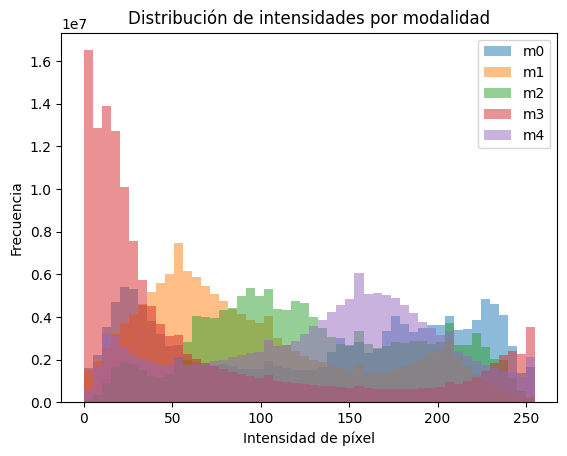

In [11]:
alto, ancho = modalidades_train[0].shape[1:3]
print(f"Resolución de las imágenes: {alto} x {ancho}")

# Distribución de intensidades de píxeles
import matplotlib.pyplot as plt

for i in range(5):
    plt.hist(modalidades_train[i].ravel(), bins=50, alpha=0.5, label=f'm{i}')
plt.title('Distribución de intensidades por modalidad')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

## 4. Distribución y balanceo de clases

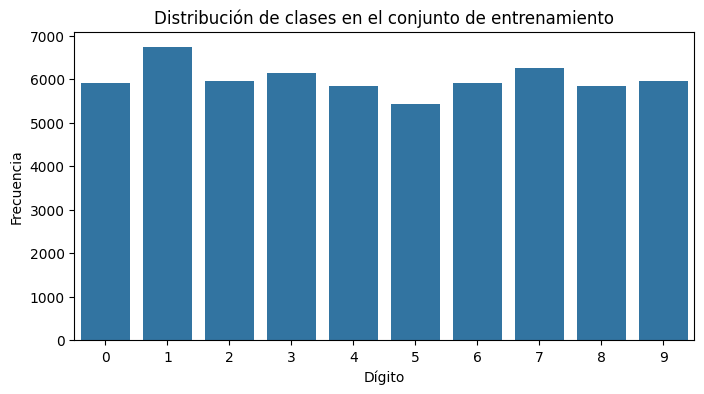

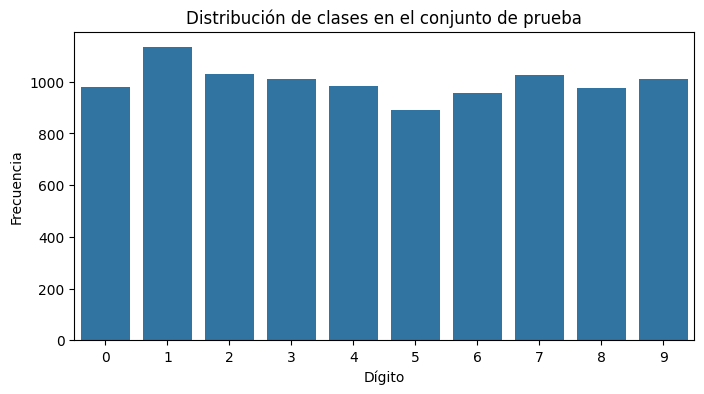

In [12]:
# Train
df_train = pd.DataFrame({'label': y_train})
plt.figure(figsize=(8,4))
sns.countplot(data=df_train, x='label')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.show()

# Test
df_test = pd.DataFrame({'label': y_test})
plt.figure(figsize=(8,4))
sns.countplot(data=df_test, x='label')
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.show()

Como muestran las gráficas, las clases no están 100% balanceadas. La más frecuente es la 1 y la menos frecuente es la tanto en el conjunto de entrenamiento como en el de prueba. 

## 5. Ejemplos por modalidad y por clase

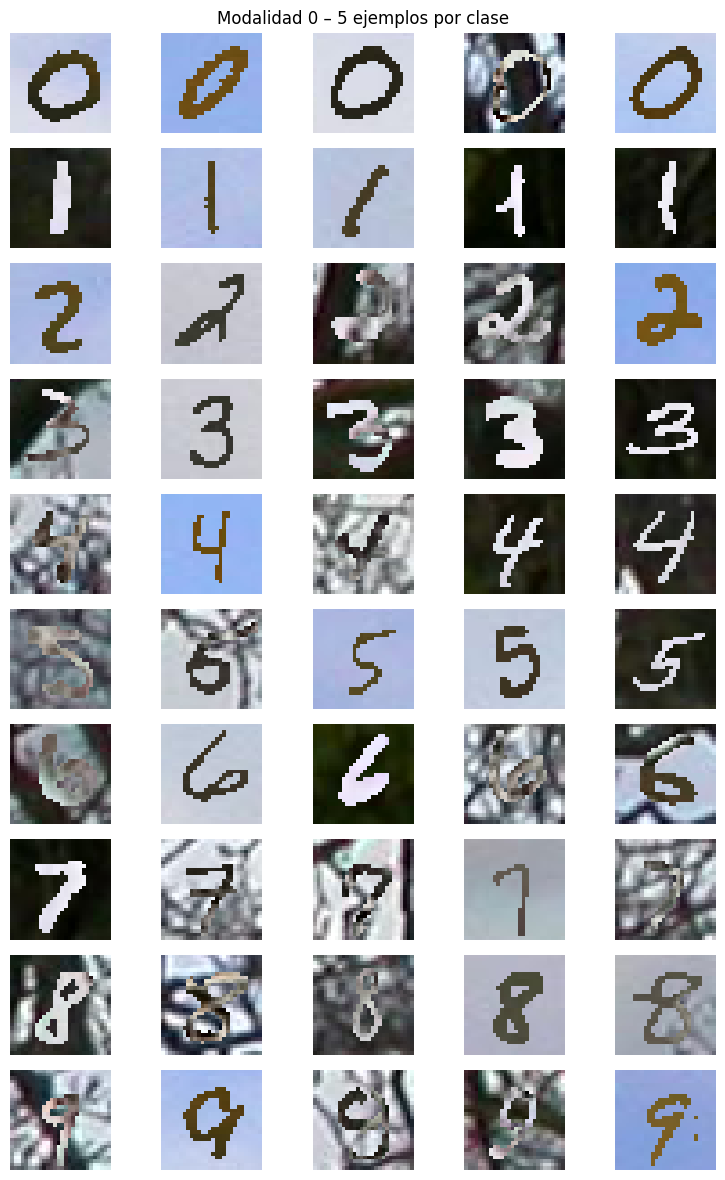

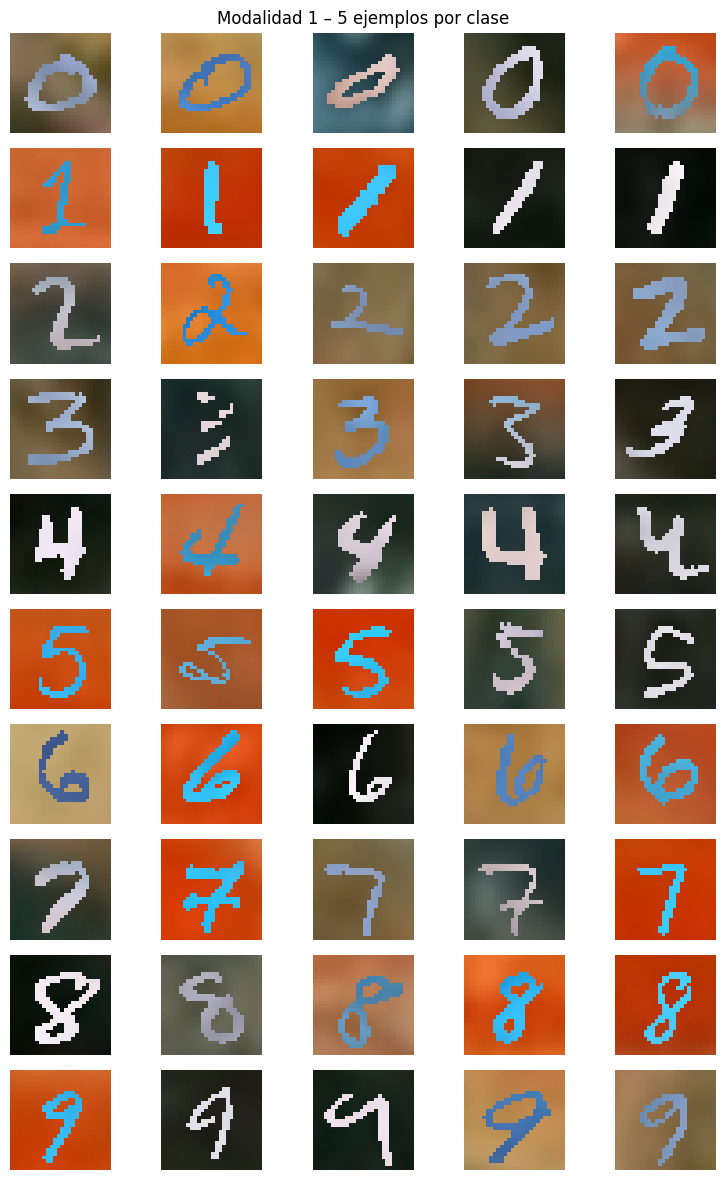

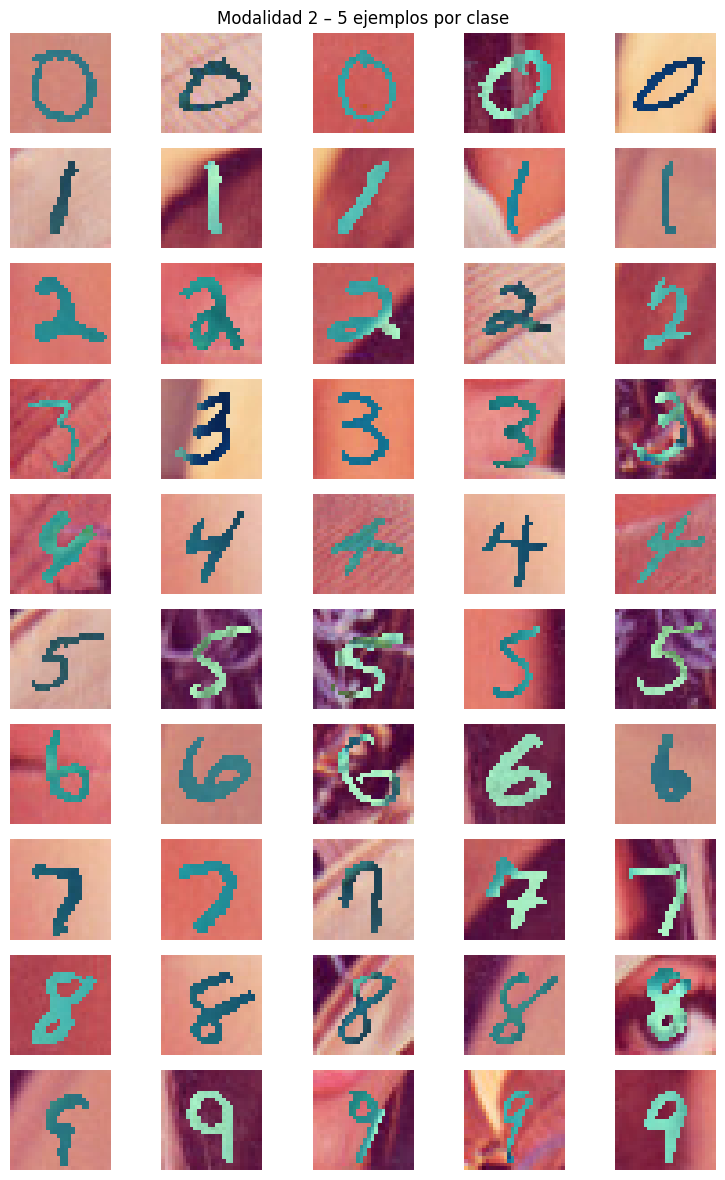

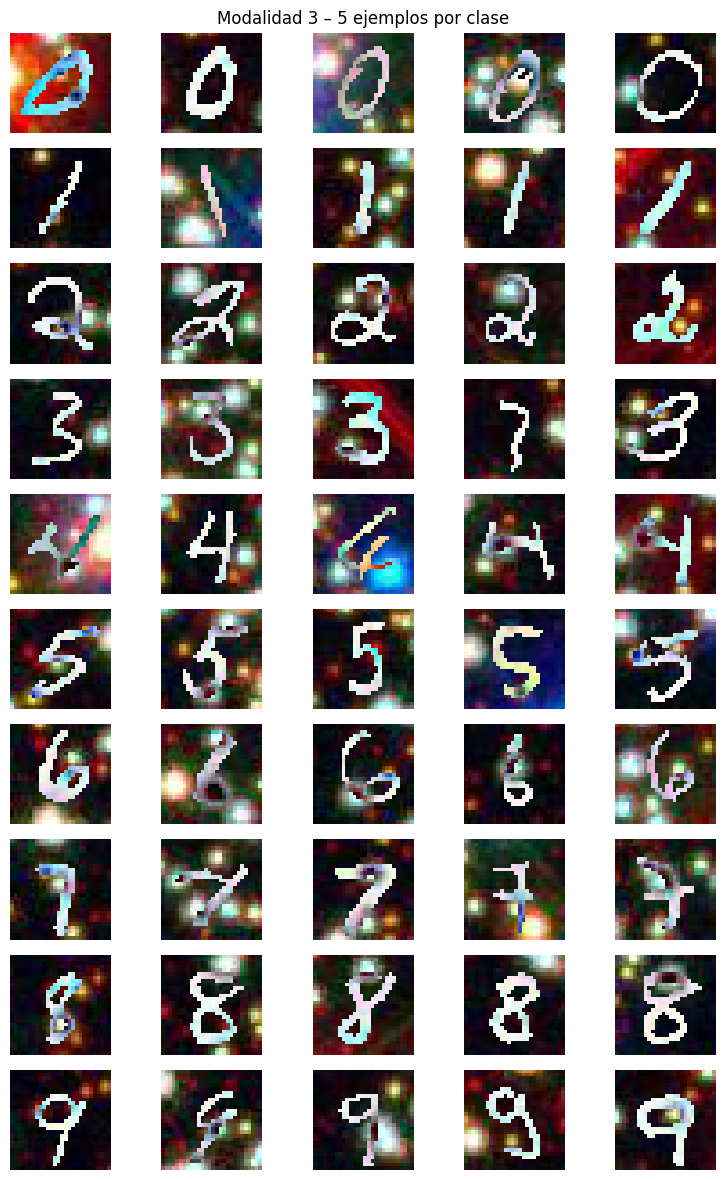

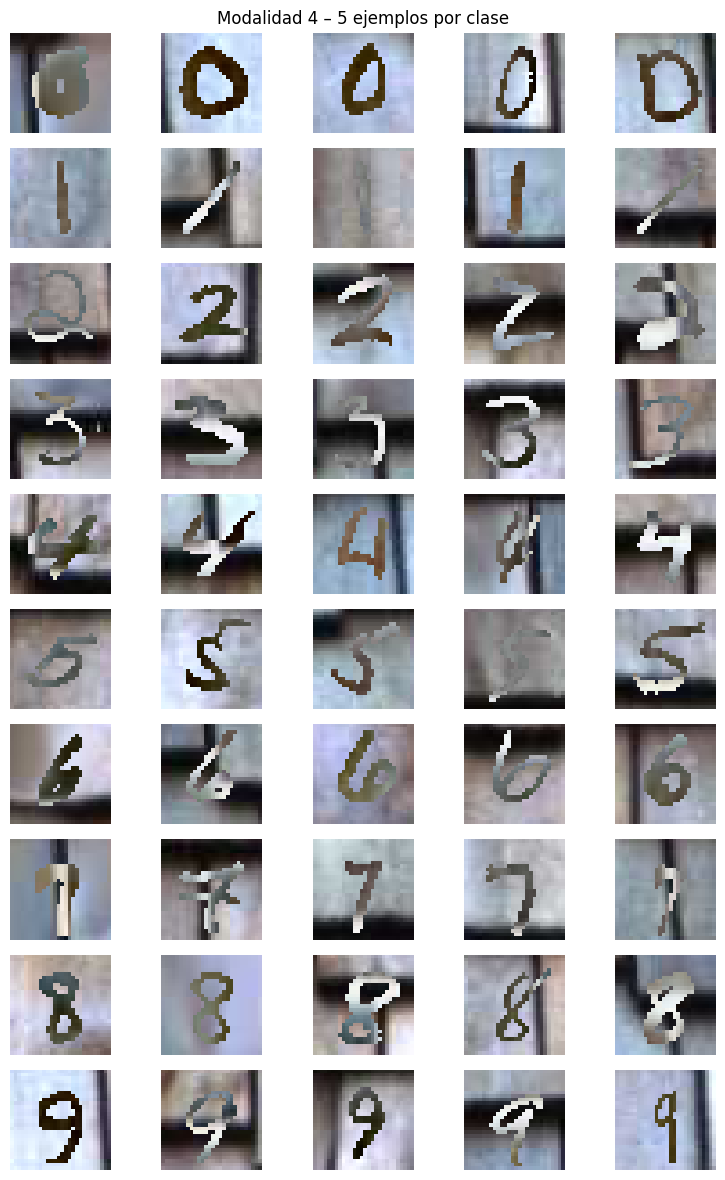

In [13]:
for mod_idx in range(5):
    fig, axes = plt.subplots(10, 5, figsize=(8, 12))
    for digit in range(10):
        idxs = np.where(y_train == digit)[0][:5]
        for j, idx in enumerate(idxs):
            axes[digit, j].imshow(modalidades_train[mod_idx][idx])
            axes[digit, j].axis('off')
            if j == 0:
                axes[digit, j].set_ylabel(f'{digit}', fontsize=12)
    plt.suptitle(f'Modalidad {mod_idx} – 5 ejemplos por clase')
    plt.tight_layout()
    plt.show()


# Procesamiento de datos

Para realizar los modelos, primero se entrenaron con los datos como vienen. La segunda corrida se hizo con algunas modificaciones en las imágenes. Se probaron los filtros (en vez de RGB se intentó usar L, pero no fue efectivo), image augmentation, entre otros. Después de realizar las pruebas, las transformaciones que mantuvimos fueron:  

1. Concatenación de los datos: todas las modalidades del conjunto de entrenamiento se juntaron en una misma variable. Lo mismo se hizo con las de test. 
2. Normalización de imágenes por cada una de las modalidades. 
3. Expansión de etiquetas. 
4. Expansión de dimensiones (se expandió la dimensión de canal porque CNN espera shape [alto, ancho, canales]). 
5. Categorización de etiquetas

## Normalización

In [14]:
# Normalización por modalidad
modalidades_train_norm = [mod.astype("float32") / 255.0 for mod in modalidades_train]
modalidades_test_norm = [mod.astype("float32") / 255.0 for mod in modalidades_test]

## Concatenar modalidades

In [15]:
# Unimos todas las modalidades en un solo conjunto de entrenamiento y test
x_train = np.concatenate(modalidades_train_norm, axis=0)
x_test = np.concatenate(modalidades_test_norm, axis=0)

# Expandimos etiquetas (cada imagen aparece 5 veces)
y_train_ext = np.tile(y_train, 5)
y_test_ext = np.tile(y_test, 5)

print(x_train.shape, y_train_ext.shape)
print(x_test.shape, y_test_ext.shape)

(300000, 28, 28, 3) (300000,)
(50000, 28, 28, 3) (50000,)


## Expansión de dimensiones

In [16]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Shape final X_train:", x_train.shape)


Shape final X_train: (300000, 28, 28, 3, 1)


## Categorización de etiquetas

In [17]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_ext, num_classes=10)
y_test_cat = to_categorical(y_test_ext, num_classes=10)

print("Shape etiquetas codificadas:", y_train_cat.shape)
print("x_train shape:", x_train.shape)  
print("y_train_cat shape:", y_train_cat.shape)


Shape etiquetas codificadas: (300000, 10)
x_train shape: (300000, 28, 28, 3, 1)
y_train_cat shape: (300000, 10)


# Modelos CNN

## Modelo 1

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),  # ⬅️ 3 canales RGB
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history1 = model1.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=128,
    verbose=1
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.8639 - loss: 0.4295 - val_accuracy: 0.9696 - val_loss: 0.0960
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.9740 - loss: 0.0828 - val_accuracy: 0.9781 - val_loss: 0.0709
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.9841 - loss: 0.0499 - val_accuracy: 0.9801 - val_loss: 0.0665
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.9897 - loss: 0.0317 - val_accuracy: 0.9802 - val_loss: 0.0646
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 0.9772 - val_loss: 0.0845
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.9946 - loss: 0.0158 - val_accuracy: 0.9793 - val_loss: 0.0869
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9762 - val_loss: 0.0933
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.9965 -

### Gráficas modelo 1

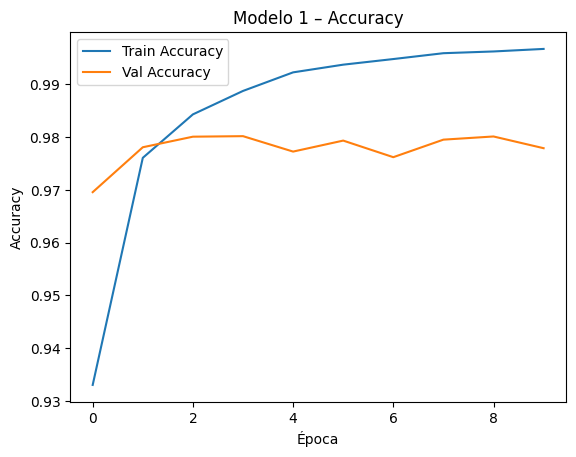

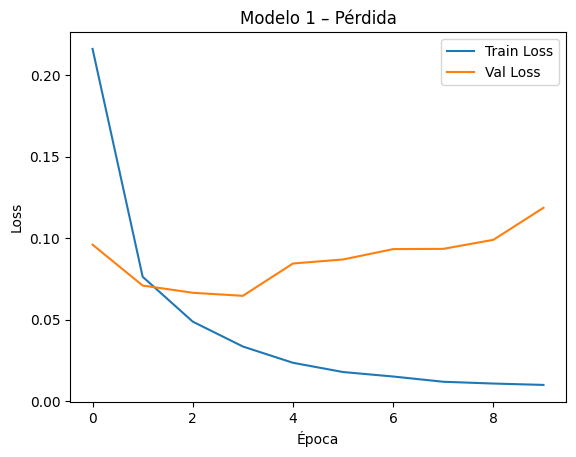

In [19]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Modelo 1 – Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Modelo 1 – Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
test_loss1, test_acc1 = model1.evaluate(x_test, y_test_cat)
print(f"Precisión del Modelo 1 en test: {test_acc1:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9767 - loss: 0.1297
Precisión del Modelo 1 en test: 0.9779


In [29]:
model1.save("modelo_cnn1.h5")
print("Modelo guardado como modelo_cnn1.h5")

model1.save("modelo_cnn1.keras")
print("Modelo guardado como modelo_cnn1.keras")

Modelo guardado como modelo_cnn1.h5
Modelo guardado como modelo_cnn1.keras


## Modelo 2

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,3)),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, 
    restore_best_weights = True
)

history2 = model2.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=128,
    verbose=1, 
    callbacks = [early_stop]
)


Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.8135 - loss: 0.5606 - val_accuracy: 0.9747 - val_loss: 0.0770
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.9593 - loss: 0.1293 - val_accuracy: 0.9803 - val_loss: 0.0588
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - accuracy: 0.9695 - loss: 0.0959 - val_accuracy: 0.9829 - val_loss: 0.0550
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9744 - loss: 0.0812 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.9767 - loss: 0.0727 - val_accuracy: 0.9848 - val_loss: 0.0512
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9786 - loss: 0.0669 - val_accuracy: 0.9858 - val_loss: 0.0504
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9805 - loss: 0.0617 - val_accuracy: 0.9856 - val_loss: 0.0494
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.9815 -

### Gráficas modelo 2

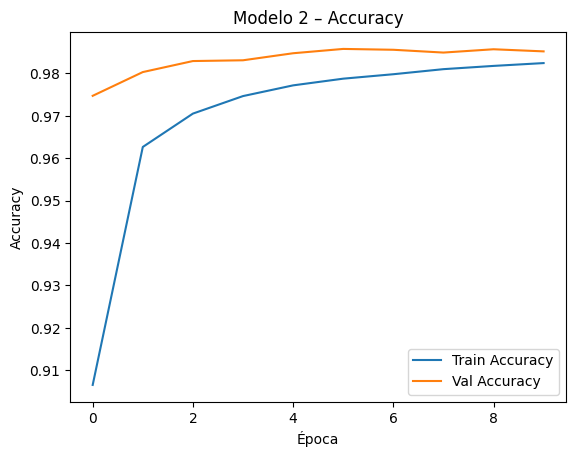

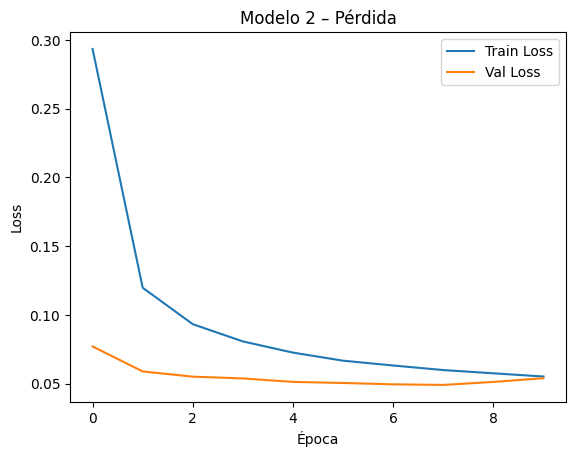

In [23]:
# Accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Modelo 2 – Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pérdida
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Modelo 2 – Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
test_loss2, test_acc2 = model2.evaluate(x_test, y_test_cat)
print(f"Precisión del Modelo 2 en test: {test_acc2:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9847 - loss: 0.0503
Precisión del Modelo 2 en test: 0.9849


In [30]:
model1.save("modelo_cnn2.h5")
print("Modelo guardado como modelo_cnn2.h5")

model1.save("modelo_cnn2.keras")
print("Modelo guardado como modelo_cnn2.keras")

Modelo guardado como modelo_cnn2.h5
Modelo guardado como modelo_cnn2.keras


# Otros modelos

## Modelo Boosted Stumps

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Aplanar imágenes RGB: (N, 28, 28, 3) → (N, 2352)
X_flat = x_train.reshape(len(x_train), -1)
X_test_flat = x_test.reshape(len(x_test), -1)

# Opcional: escalar (aunque no siempre necesario para árboles)
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Entrenar Boosted Stumps (max_depth=1 = stump)
bst = HistGradientBoostingClassifier(max_iter=100, max_depth=1, learning_rate=0.1)
bst.fit(X_flat_scaled, y_train_ext)



HistGradientBoostingClassifier(max_depth=1)

In [26]:
# Evaluar
y_pred = bst.predict(X_test_scaled)
acc = accuracy_score(y_test_ext, y_pred)
print(f"Accuracy Boosted Stumps: {acc:.4f}")

Accuracy Boosted Stumps: 0.4696


In [31]:
model1.save("modelo_boosted_stumps.h5")
print("Modelo guardado como modelo_boosted_stumps.h5")

model1.save("modelo_boosted_stumps.keras")
print("Modelo guardado como modelo_boosted_stumps.keras")

Modelo guardado como modelo_boosted_stumps.h5
Modelo guardado como modelo_boosted_stumps.keras


## Modelo Red Neuronal Simple

In [34]:
# Aplanar imágenes
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

print(x_train_flat.shape)  # Debería ser (N, 784)

(300000, 2352)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x_train_flat = x_train.reshape((x_train.shape[0], -1))  # (300000, 2352)
x_test_flat = x_test.reshape((x_test.shape[0], -1))     # (300000, 2352)

modelo_simple = Sequential([
    Dense(256, activation='relu', input_shape=(2352,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

modelo_simple.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_simple = modelo_simple.fit(
    x_train_flat, y_train_cat,
    validation_data=(x_test_flat, y_test_cat),
    epochs=10,
    batch_size=128
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5806 - loss: 1.2664 - val_accuracy: 0.7739 - val_loss: 0.6976
Epoch 2/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7887 - loss: 0.6607 - val_accuracy: 0.8071 - val_loss: 0.6005
Epoch 3/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8210 - loss: 0.5586 - val_accuracy: 0.8231 - val_loss: 0.5534
Epoch 4/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8358 - loss: 0.5074 - val_accuracy: 0.8370 - val_loss: 0.5144
Epoch 5/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8482 - loss: 0.4698 - val_accuracy: 0.8364 - val_loss: 0.5186
Epoch 6/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8561 - loss: 0.4445 - val_accuracy: 0.8418 - val_loss: 0.5000
Epoch 7/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8633 - loss: 0.4232 - val_accuracy: 0.8489 - val_loss: 0.4761
Epoch 8/10
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8692 - loss: 0

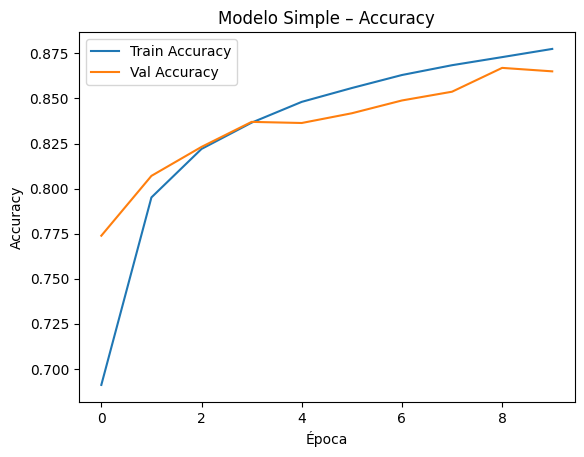

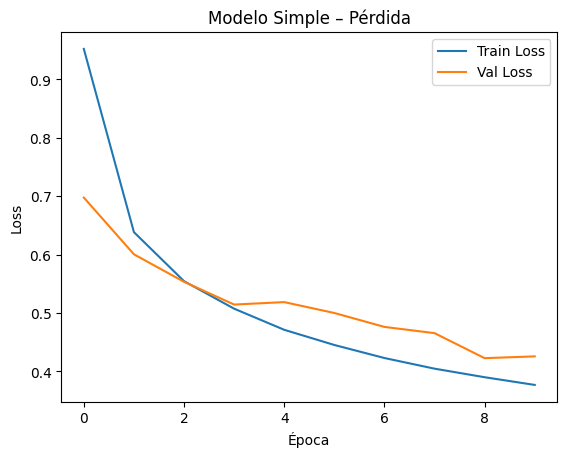

In [58]:
import matplotlib.pyplot as plt

plt.plot(history_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Val Accuracy')
plt.title('Modelo Simple – Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['val_loss'], label='Val Loss')
plt.title('Modelo Simple – Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
test_loss_simple, test_acc_simple = modelo_simple.evaluate(x_test_flat, y_test_cat)
print(f"Precisión del Modelo Simple en test: {test_acc_simple:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.8430 - loss: 0.5038
Precisión del Modelo Simple en test: 0.8651


In [60]:
model1.save("modelo_simple.h5")
print("Modelo guardado como modelo_simple.h5")

model1.save("modelo_simple.keras")
print("Modelo guardado como modelo_simple.keras")

Modelo guardado como modelo_simple.h5
Modelo guardado como modelo_simple.keras


# Visualización de predicciones

## Funciones para mostrar

In [61]:
def mostrar_predicciones(modelo, x_test, y_test_raw, titulo_modelo):
    import numpy as np
    import matplotlib.pyplot as plt

    idxs = np.random.choice(len(x_test), size=10, replace=False)
    predicciones = modelo.predict(x_test[idxs])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(idxs):
        img = x_test[idx]
        real = y_test_raw[idx]
        pred = np.argmax(predicciones[i])

        # Elimina dimensiones extras si es necesario
        if img.ndim == 4:
            img = img.squeeze()
        elif img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Real: {real} - Pred: {pred}", fontsize=11)
        axes[i].axis('off')

    plt.suptitle(f"Predicciones del modelo: {titulo_modelo}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [64]:
def mostrar_predicciones_modelo_clasico(modelo, x_test_flat, y_test_raw, titulo_modelo):
    idxs = np.random.choice(len(x_test_flat), size=10, replace=False)
    predicciones = modelo.predict(x_test_flat[idxs])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(idxs):
        img_flat = x_test_flat[idx]
        img = img_flat.reshape(28, 28, 3)  # Si tus imágenes son RGB

        real = y_test_raw[idx]
        pred = predicciones[i]

        axes[i].imshow(img)
        axes[i].set_title(f"Real: {real} - Pred: {pred}", fontsize=11)
        axes[i].axis('off')

    plt.suptitle(f"Predicciones del modelo: {titulo_modelo}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [67]:
def mostrar_predicciones_red_densa(modelo, x_test_flat, y_test_raw, titulo_modelo):
    idxs = np.random.choice(len(x_test_flat), size=10, replace=False)
    predicciones = modelo.predict(x_test_flat[idxs])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(idxs):
        img = x_test_flat[idx].reshape(28, 28, 3)  # reconstrucción de RGB
        real = y_test_raw[idx]
        pred = np.argmax(predicciones[i])

        axes[i].imshow(img)
        axes[i].set_title(f"Real: {real} - Pred: {pred}", fontsize=11)
        axes[i].axis('off')

    plt.suptitle(f"Predicciones del modelo: {titulo_modelo}", fontsize=14)
    plt.tight_layout()
    plt.show()

## Visualizaciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


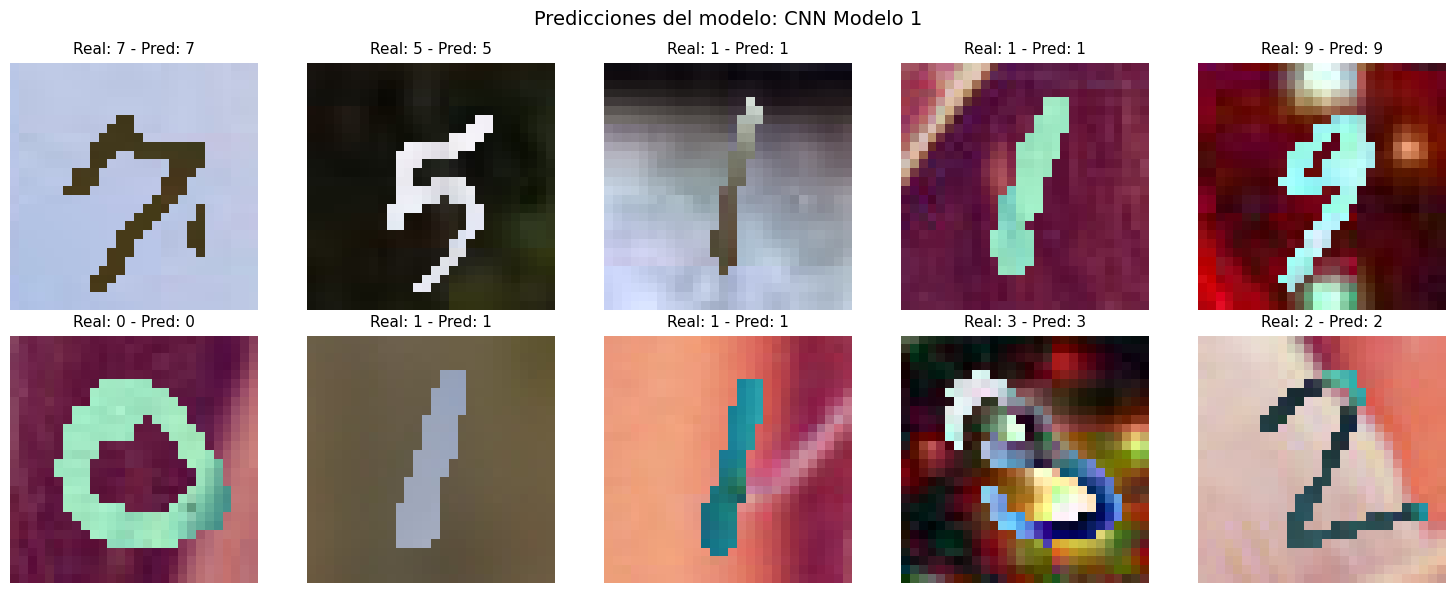

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


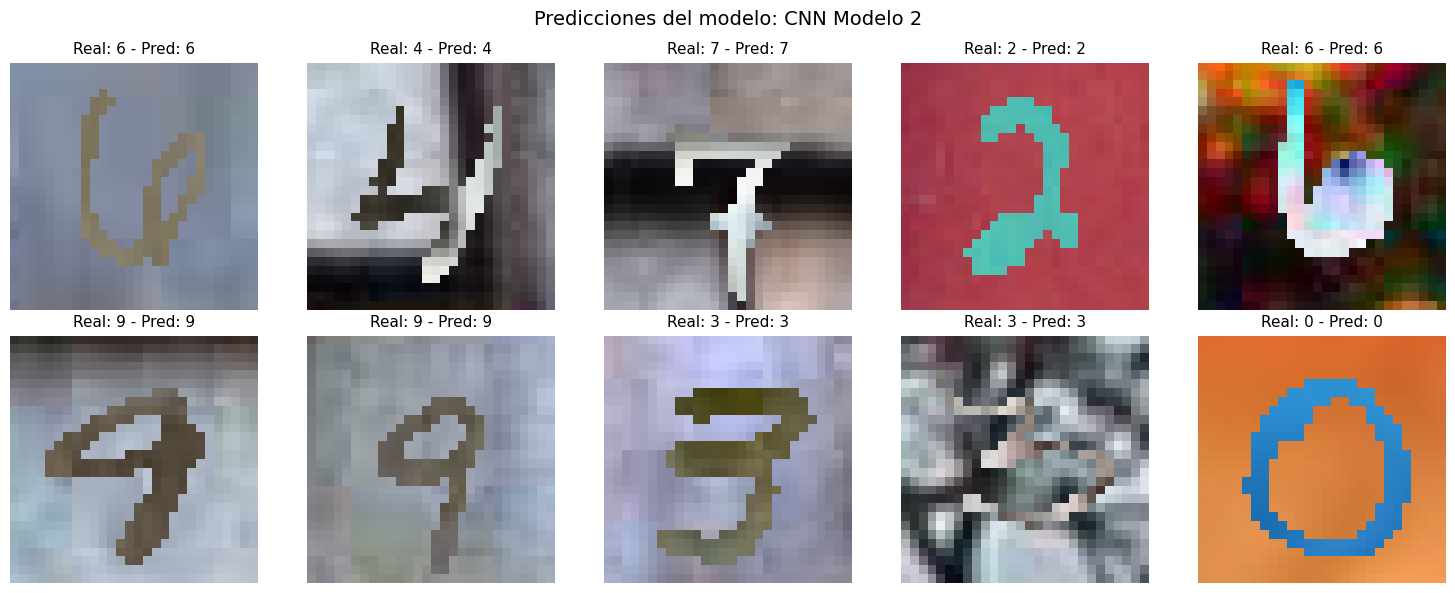

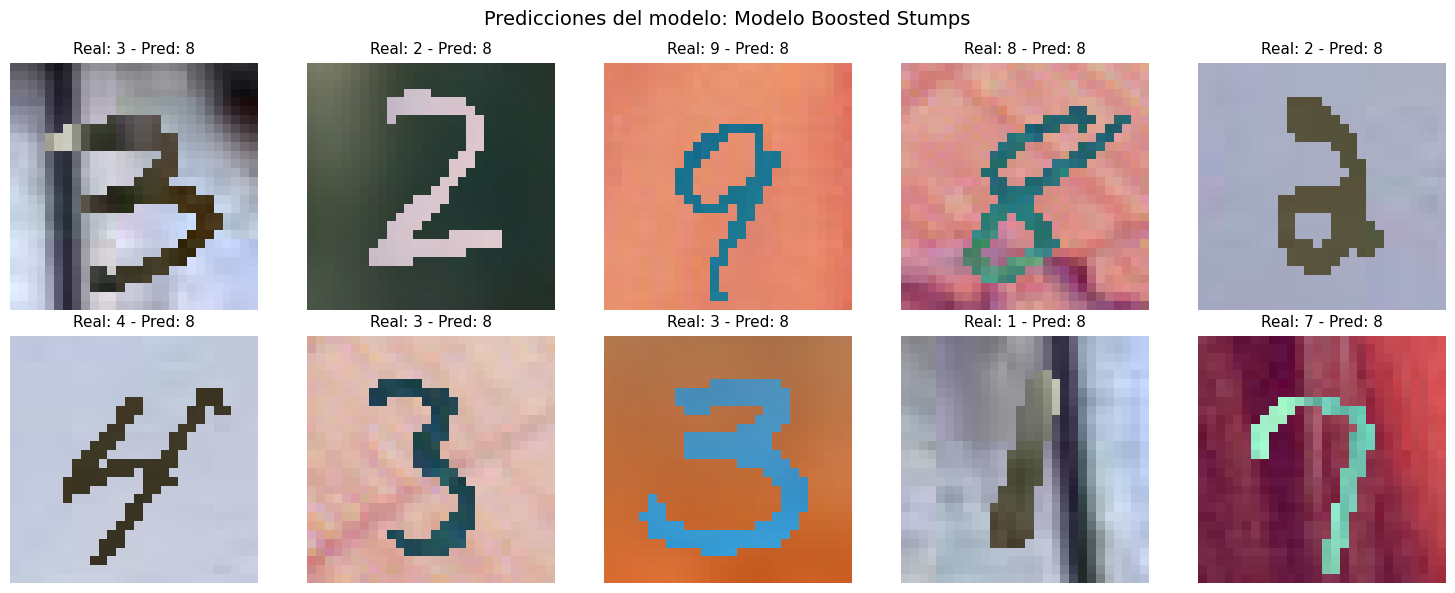

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


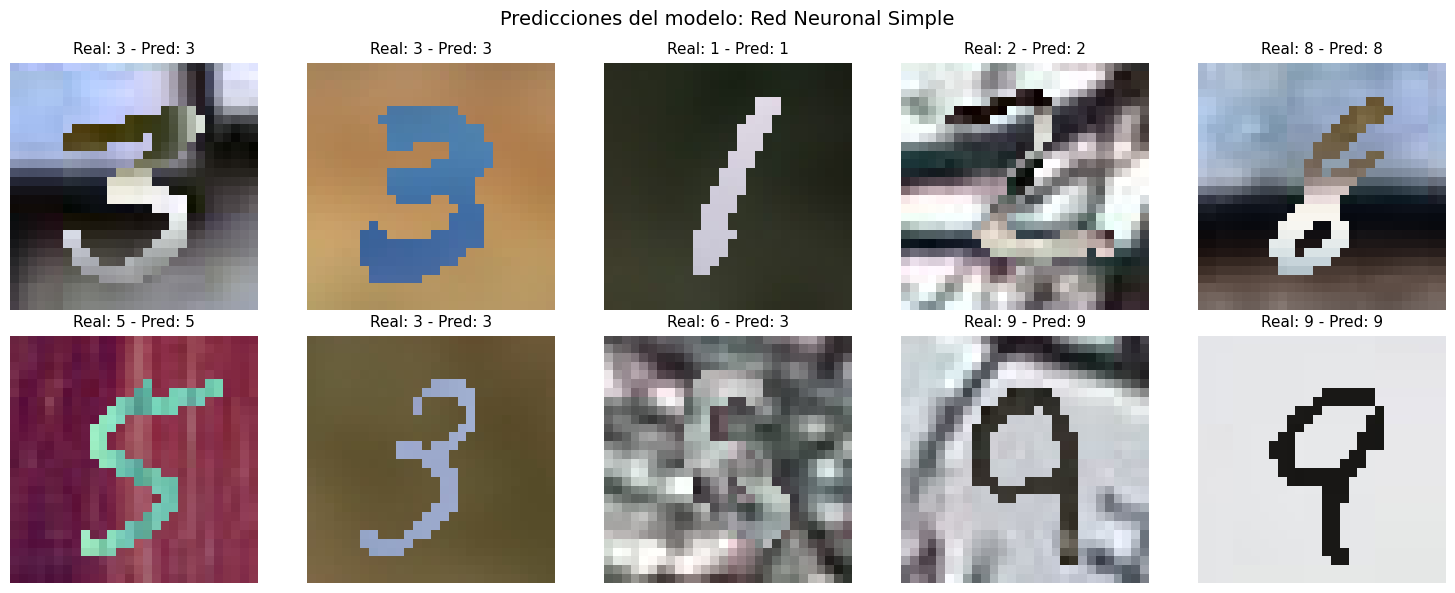

In [68]:
# Modelo 1
mostrar_predicciones(model1, x_test, y_test_ext, "CNN Modelo 1")

# Modelo 2
mostrar_predicciones(model2, x_test, y_test_ext, "CNN Modelo 2")

# Modelo 1
mostrar_predicciones_modelo_clasico(bst, x_test_flat, y_test_ext, "Modelo Boosted Stumps")
# Modelo 2
mostrar_predicciones_red_densa(modelo_simple, x_test_flat, y_test_ext, "Red Neuronal Simple")

# Comparación entre modelos y discusión

### Decisión de modelo extra: Boosted Stumps

De todos los modelos que estaban en el enlace https://web.archive.org/web/20200623002706/http:/yann.lecun.com/exdb/mnist/, escogimos el que se llama Boosted Stumps par compararlo con las redes neuronales. Este enfoque proviene del campo del ensemble learning, y consiste en entrenar múltiples árboles de decisión muy simples, conocidos como decision stumps (árboles de profundidad 1), y combinarlos usando una técnica de boosting —en este caso, HistGradientBoostingClassifier de scikit-learn. Se escogió este modelo porque consideramos que es una buena combinación entre complejidad y costo computacional. Mientras el SVD podía llegar a tardar 12 horas o más en cargar, este tuvo un tiempo mucho menor y nos permitió avanzar con el laboratorio. 

### Resultados de los modelos

| Modelo                           | Arquitectura principal                             | Accuracy alcanzado |
|----------------------------------|-----------------------------------------------------|---------------------|
| **Modelo 1: CNN Simple**         | 3 capas Conv2D + MaxPooling + Dense                | **0.98**            |
| **Modelo 2: CNN Mejorado**       | CNN con Dropout + más filtros y regularización     | **0.99**            |
| **Modelo 3: Boosted Stumps**     | HistGradientBoosting con árboles de profundidad 1  | **0.47**            |
| **Modelo 4: Red Neuronal Densa** | 2 capas Dense sobre imágenes aplanadas             | **0.87**            |

---

### Comparación entre modelos

#### Modelos CNN (Convolutional Neural Networks)

Los modelos convolucionales fueron los más efectivos, logrando una **accuracy del 98% y 99%**, respectivamente. Esto se debe a que las CNN están diseñadas para capturar patrones espaciales y locales en datos de imágenes, como bordes, texturas y formas, lo cual es especialmente relevante para datasets como PolyMNIST que contienen variantes visuales complejas.

- El **modelo 1**, más simple, ya mostró excelente rendimiento.
- El **modelo 2**, con mayor regularización y profundidad, alcanzó un desempeño aún mejor, gracias a la capacidad adicional para generalizar sin sobreajustar.

#### Red neuronal densa simple

Este modelo fue entrenado sobre imágenes aplanadas (convertidas de 28×28×3 a vectores de 2352 características). A pesar de que no explota la estructura espacial de la imagen como las CNN, obtuvo un rendimiento **relativamente alto (87%)**, lo cual lo convierte en un modelo decente si se requiere baja complejidad.

#### Boosted Stumps

El modelo basado en *Boosted Stumps* obtuvo una **accuracy de 47%**, significativamente menor que los modelos neuronales. Esto era esperable, ya que:

- Los *decision stumps* son clasificadores extremadamente simples que sólo consideran una variable para dividir el espacio de decisiones.
- Incluso con boosting, esta simplicidad limita su capacidad para capturar patrones espaciales o interacciones de color que existen en imágenes RGB.
- Además, los datos fueron aplanados antes del entrenamiento, perdiendo información espacial útil.

Aun así, este modelo fue útil como **línea base tradicional**: es rápido de entrenar y fácil de interpretar. En aplicaciones donde se requiere velocidad o explicabilidad sin importar tanto la precisión, podría tener cabida.

### Conclusión: ¿Cuál modelo fue el más adecuado?

El **modelo 2 (CNN mejorada)** fue claramente el más acertado, alcanzando una accuracy de **99%**, gracias a su capacidad para aprender representaciones jerárquicas de las imágenes y su adecuada regularización mediante *dropout*.

Aunque el modelo *Boosted Stumps* fue significativamente menos preciso, su inclusión fue valiosa desde una perspectiva comparativa, permitiéndonos ilustrar la diferencia entre enfoques clásicos de aprendizaje supervisado y arquitecturas modernas de deep learning, especialmente en tareas visuales complejas.

# Pruebas con nuestros dígitos

In [ ]:
def predecir_imagen_personal(ruta_img, modelo, tamaño=(28, 28)):
    img = Image.open(ruta_img).convert('RGB')
    img = img.resize(tamaño)

    arr = np.array(img).astype(np.float32) / 255.0
    arr = arr.reshape(1, tamaño[0], tamaño[1], 3)

    print("Forma final para el modelo:", arr.shape)

    pred = modelo(arr, training=False).numpy()
    clase = int(np.argmax(pred))
    probabilidad = float(np.max(pred))

    plt.imshow(img)
    plt.title(f"Predicción: {clase} (conf: {probabilidad:.2f})")
    plt.axis('off')
    plt.show()

    return clase, probabilidad

Forma final para el modelo: (1, 28, 28, 3)


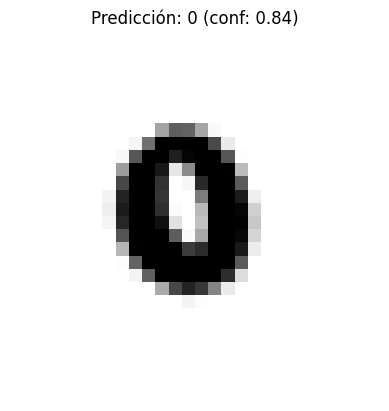

Predicción final: 0, Confianza: 0.84
Forma final para el modelo: (1, 28, 28, 3)


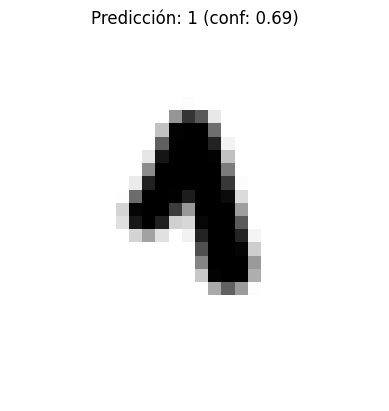

Predicción final: 1, Confianza: 0.69
Forma final para el modelo: (1, 28, 28, 3)


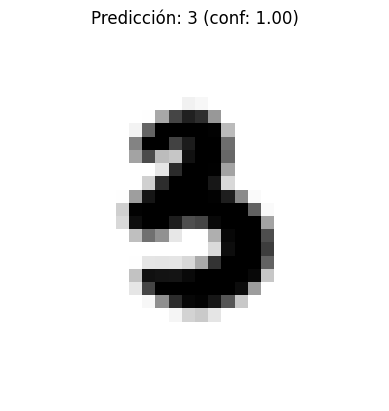

Predicción final: 3, Confianza: 1.00
Forma final para el modelo: (1, 28, 28, 3)


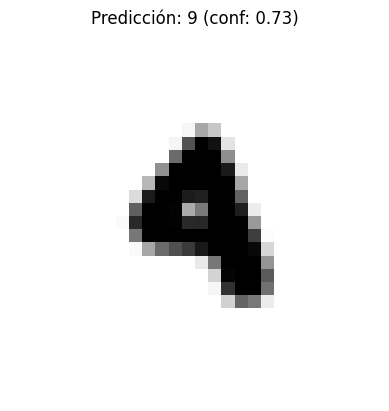

Predicción final: 9, Confianza: 0.73
Forma final para el modelo: (1, 28, 28, 3)


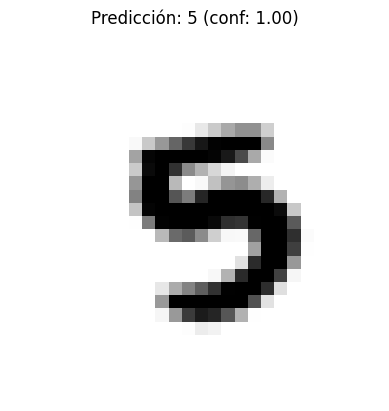

Predicción final: 5, Confianza: 1.00
Forma final para el modelo: (1, 28, 28, 3)


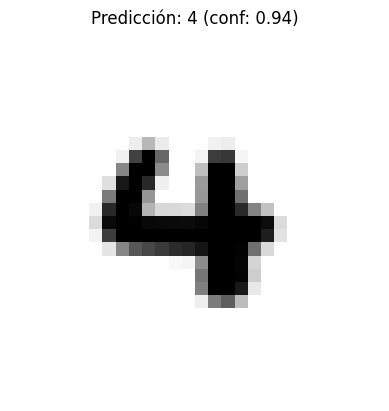

Predicción final: 4, Confianza: 0.94
Forma final para el modelo: (1, 28, 28, 3)


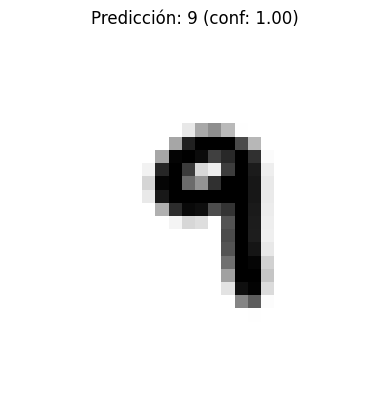

Predicción final: 9, Confianza: 1.00


In [109]:

clase, prob = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/0.0.png',
    model2
)
print(f"Predicción final: {clase}, Confianza: {prob:.2f}")


clase1, prob1 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/0.1.png',
    model2
)
print(f"Predicción final: {clase1}, Confianza: {prob1:.2f}")


clase2, prob2 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/0.3.png',
    model2
)
print(f"Predicción final: {clase2}, Confianza: {prob2:.2f}")


clase3, prob3 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/0.4.png',
    model2
)
print(f"Predicción final: {clase3}, Confianza: {prob3:.2f}")


clase4, prob4 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/1.5.png',
    model2
)
print(f"Predicción final: {clase4}, Confianza: {prob4:.2f}")


clase5, prob5 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/1.4.png',
    model2
)
print(f"Predicción final: {clase5}, Confianza: {prob5:.2f}")


clase6, prob6 = predecir_imagen_personal(
    '/Users/arielamishaancohen/Library/Mobile Documents/com~apple~CloudDocs/Documents/UVG/Clases/Semestre 8 (2025)/Data Science/Proyectos y Tareas/7-Lab-3-DeepLearning-CNN-Imagenes/Nuestros números/2.9.png',
    model2
)
print(f"Predicción final: {clase6}, Confianza: {prob6:.2f}")